In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import time
import jax.numpy as jnp
from jax import partial, jit, vmap, grad, random, lax
from jax.scipy.special import logsumexp

import context

from examples.PMF.pmf_model import grad_log_post
from examples.PMF.util import R_train, R_test, flatten_PMF_params, load_PMF_MAP
from examples.PMF.sgld_PMF_functions import sgld_PMF_time_budget_CV, sgld_PMF_time_budget, sgld_PMF_time_budget_svrg
from examples.PMF.adam import sgld_adam_PMF_time_budget
from examples.PMF.sghmc import run_sghmc_PMF, run_sghmc_PMF_time_budget


from ksd import imq_KSD
from util import progress_bar_scan, wait_until_computed

/Users/jeremiecoullon/Documents/research/papers/SGMCMC_bandit_tuning/venv/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/jeremiecoullon/Documents/research/papers/SGMCMC_bandit_tuning/venv/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# plot KSD as a function of time budget

See end of notebook to reproduce the figures

In [2]:
def get_fb_grads_pmf(samples):
    """
    Return full-batch gradients for PMF samples
    samples list of PMF sample. Each PMF sample is a list of 6 arrays
    """
    return [grad_log_post(sam, R_train) for sam in samples]

In [50]:
# key = random.PRNGKey(0)
# MAP_params = load_PMF_MAP()
# # dt = 1e-6
# # batch_size = int(0.1*R_train.shape[0])

# dt = 10**(-4.65)
# batch_size = int(0.016*R_train.shape[0])

# time_budget = 1

# a, b = sgld_PMF_time_budget(key, time_budget, grad_log_post, dt, batch_size, MAP_params, R_train, save_rate=30)

# flat_samples = flatten_PMF_params(a)
# flat_grads = flatten_PMF_params(b)

# # imq_KSD(flat_samples, flat_grads)
# print(flat_samples.shape)

# print(f"Total samples: {flat_samples.shape[0]*30}")

## Define functions

1. Get gradients in batches
2. get KSD list for different time budgets

In [3]:
def get_KSD_list_time_budget_PMF(max_time_budget, time_steps, sampler_fun, thin_step=2, start_time=5):
    "Get the KSD for a sampler run for each time budget up to `max_time_budget`"
    ksd_list = []
    for time_budget in np.arange(start_time, max_time_budget, time_steps):
        print(f"Running for time budget={time_budget}sec")
        samples = sampler_fun(time_budget)
        print(f"Num samples: {len(samples)}")
        fb_grads = get_fb_grads_pmf(samples[::thin_step])
        
        flat_samples = flatten_PMF_params(samples[::thin_step])
        flat_grads = flatten_PMF_params(fb_grads)
        
        ksd_est = imq_KSD(flat_samples, flat_grads)
        ksd_list.append(ksd_est)
        print(f"KSD: {ksd_est:.1f}")
        print("\n")
    return ksd_list
    


# sgld:

- Set `save_rate=30` (as usual)
- Then thin by 2 again in `get_KSD_list_time_budget_PMF`

# SGLD

- default: `log_dt =`, `b_s_r = 0.1`

## Average KSD curves



### run for the 3 SH results

#### R = 10sec with n=90


`key=0`:
- v1: -4.41, 0.0046
- v2: -4.60, 0.027
- v3: -4.65, 0.016

`key=1`:
- v4: -4.48, 0.01
- v5: -4.56, 0.022
- v6: -4.66, 0.038

`key=2`:
- v7: -4.71, 0.011
- v8: -4.67, 0.023
- v9: -5.07, 0.0038

 

In [3]:
def run_many_KSD_curves_sgld(list_params):
    list_KSD_curves = []
    
    starttime = time.time()
    for log_dt, b_s_r in list_params:
        print(f"\nCalculating KSD curve for {log_dt, b_s_r}:")
        def run_sgld_sampler(time_budget):
            key = random.PRNGKey(0)
            MAP_params = load_PMF_MAP()
            dt = 10**(log_dt)
            batch_size = int(b_s_r*R_train.shape[0])
            samples, _ = sgld_PMF_time_budget(key, time_budget, grad_log_post, 
                                      dt, batch_size, MAP_params, R_train, save_rate=30)
            return samples
        
        # ===
        max_time_budget =  20
        time_steps = 2
        thin_step = 2
        
        ksd_list_sgld_SH = get_KSD_list_time_budget_PMF(max_time_budget, time_steps, 
                                                        run_sgld_sampler, thin_step=thin_step)
        list_KSD_curves.append(ksd_list_sgld_SH)
    print(f"Running time: {(time.time()-starttime)/60:.1f} min")
    return list_KSD_curves

In [6]:
# n=90
list_params_sgld_10 = [(-4.41, 0.0046),(-4.60, 0.027), (-4.65, 0.016),
                      ( -4.48, 0.01), (-4.56, 0.022), (-4.66, 0.038),
                      (-4.71, 0.011), (-4.67, 0.023), (-5.07, 0.0038)
                     ]

# list_KSD_curves_sgld_10 = run_many_KSD_curves_sgld(list_params_sgld_10)

### load/save KSD curves for SH - 10 sec

In [4]:
# n=90
# save all KSD curves
# for idx, elem in enumerate(list_KSD_curves_sgld_10):
#     np.savetxt(f"outputs/KSD_list/PMF/sgld-SH_10-n_90/ksd_curve_{idx}.csv", elem)

# load all KSD curves
list_KSD_curves_sgld_10 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/PMF/sgld-SH_10-n_90/ksd_curve_{idx}.csv")
    list_KSD_curves_sgld_10.append(mylist)

In [8]:
# def sgld_sampler_default(time_budget):
    
#     key = random.PRNGKey(0)
#     MAP_params = load_PMF_MAP()
#     dt = 10**(-3.3)
#     batch_size = int(0.1*R_train.shape[0])
#     samples, _ = sgld_PMF_time_budget(key, time_budget, grad_log_post, 
#                               dt, batch_size, MAP_params, R_train, save_rate=30)
#     return samples


# # ===
# max_time_budget = 20
# time_steps = 2
# thin_step = 2
# ksd_list_sgld_default = get_KSD_list_time_budget_PMF(max_time_budget, time_steps, sgld_sampler_default, thin_step=thin_step)


# def sgld_sampler_adam(time_budget):
#     key = random.PRNGKey(0)
#     dt = 1e-3
#     batch_size = int(R_train.shape[0]*0.1)
#     params_IC = load_PMF_MAP()
#     samples, _ = sgld_adam_PMF_time_budget(key, time_budget, dt, 
#                                                batch_size, R_train, params_IC, save_rate=30)
#     return samples


# # ===
# max_time_budget = 20
# time_steps = 2
# thin_step = 2

# ksd_list_adam = get_KSD_list_time_budget_PMF(max_time_budget, time_steps, sgld_sampler_adam, thin_step=thin_step)


### load/save KSD curves for adam and default samplers

In [5]:
# np.savetxt(f"outputs/KSD_list/PMF/ksd_curve_adam.csv", ksd_list_adam)
# np.savetxt(f"outputs/KSD_list/PMF/ksd_curve_sgld_default.csv", ksd_list_sgld_default)


ksd_list_adam = np.genfromtxt(f"outputs/KSD_list/PMF/ksd_curve_adam.csv")
ksd_list_sgld_default = np.genfromtxt(f"outputs/KSD_list/PMF/ksd_curve_sgld_default.csv")

### save KSD list arrays

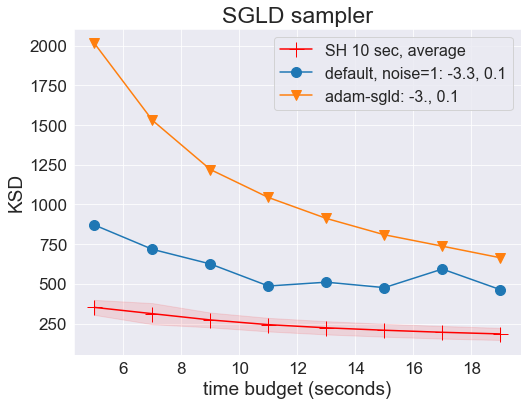

In [6]:
plt.rcParams.update({'font.size':17})

average_curve_sgld_SH10 = np.mean(list_KSD_curves_sgld_10, axis=0)
std_curve_sgld_SH10 = np.std(list_KSD_curves_sgld_10, axis=0)



max_time_budget = 20

plt.figure(figsize=(8, 6))

plt.plot(np.arange(5, max_time_budget, 2), average_curve_sgld_SH10, marker="+", markersize=15, 
         c='r', label="SH 10 sec, average")
plt.fill_between(np.arange(5, max_time_budget, 2), average_curve_sgld_SH10+2*std_curve_sgld_SH10, 
                 average_curve_sgld_SH10-2*std_curve_sgld_SH10, alpha=0.1, color='r')



# for elem in list_KSD_curves_sgld_10[:]:
#     plt.plot(np.arange(5, max_time_budget, 2), elem, alpha=0.4, marker="v")
    
plt.plot(np.arange(5, max_time_budget, 2), ksd_list_sgld_default, marker="o", label="default, noise=1: -3.3, 0.1", markersize=10)
plt.plot(np.arange(5, max_time_budget, 2), ksd_list_adam, marker="v", label="adam-sgld: -3., 0.1", markersize=10)


plt.title("SGLD sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/PMF_sgld_ksd_curves.png") 

### compare posterior variance to NUTS

In [12]:
from config import BASE_DIR

def load_PMF_NUTS_stds():
    return [np.genfromtxt(f"{BASE_DIR}/data/PMF_NUTS_stds/PMF_{idx}_std.txt") for idx in range(6)]


numpyro_stds = load_PMF_NUTS_stds()

##### 1. sgld-SH

In [86]:
key = random.PRNGKey(0)
MAP_params = load_PMF_MAP()

# use parameters from the 1st SH chain (from list_params_sgld_10`)
dt = 10**(-4.41)
batch_size = int(0.0046*R_train.shape[0])
time_budget = 200.

samples_SH, _ = sgld_PMF_time_budget(key, time_budget, grad_log_post, dt, batch_size, MAP_params, R_train, save_rate=30)

print(f"Number of samples: {len(samples_SH)*30:,}")

Number of samples: 168,030


In [88]:
samples_std_SH = []
for idx in range(6):
    samples_std_SH.append(np.std([elem[idx] for elem in samples_SH], axis=0))
    
list_rel_error_SH = []
for idx in range(6):
        list_rel_error_SH.append(np.linalg.norm(samples_std_SH[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

mean_variance_error_SH = np.mean(list_rel_error_SH)

print(mean_variance_error_SH)

0.6297671811671397


##### 2. default

In [89]:
key = random.PRNGKey(0)
MAP_params = load_PMF_MAP()
dt = 10**(-3.3)
batch_size = int(0.1*R_train.shape[0])
time_budget = 200.

samples_default, _ = sgld_PMF_time_budget(key, time_budget, grad_log_post, 
                                dt, batch_size, MAP_params, R_train, save_rate=30)


print(f"Number of samples: {len(samples_default)*30:,}")

Number of samples: 102,090


In [91]:
samples_std_default = []
for idx in range(6):
    samples_std_default.append(np.std([elem[idx] for elem in samples_default], axis=0))

list_rel_error_default = []
for idx in range(6):
        list_rel_error_default.append(np.linalg.norm(samples_std_default[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

        
mean_variance_error_default = np.mean(list_rel_error_default)

print(mean_variance_error_default)

44.7474009102481


#### 3. sgld-adam

In [92]:
time_budget = 200.

key = random.PRNGKey(0)
dt = 1e-3
batch_size = int(R_train.shape[0]*0.1)
params_IC = load_PMF_MAP()
samples_sgldadam, _ = sgld_adam_PMF_time_budget(key, time_budget, dt, 
                                batch_size, R_train, params_IC, save_rate=30)

print(f"Number of samples: {len(samples_sgldadam)*30:,}")

Compiling
Running
Iteration 2000. Time: 4 / 200.0 sec
Iteration 4000. Time: 8 / 200.0 sec
Iteration 6000. Time: 13 / 200.0 sec
Iteration 8000. Time: 17 / 200.0 sec
Iteration 10000. Time: 21 / 200.0 sec
Iteration 12000. Time: 26 / 200.0 sec
Iteration 14000. Time: 30 / 200.0 sec
Iteration 16000. Time: 34 / 200.0 sec
Iteration 18000. Time: 39 / 200.0 sec
Iteration 20000. Time: 43 / 200.0 sec
Iteration 22000. Time: 47 / 200.0 sec
Iteration 24000. Time: 52 / 200.0 sec
Iteration 26000. Time: 56 / 200.0 sec
Iteration 28000. Time: 61 / 200.0 sec
Iteration 30000. Time: 66 / 200.0 sec
Iteration 32000. Time: 71 / 200.0 sec
Iteration 34000. Time: 75 / 200.0 sec
Iteration 36000. Time: 80 / 200.0 sec
Iteration 38000. Time: 85 / 200.0 sec
Iteration 40000. Time: 90 / 200.0 sec
Iteration 42000. Time: 95 / 200.0 sec
Iteration 44000. Time: 99 / 200.0 sec
Iteration 46000. Time: 104 / 200.0 sec
Iteration 48000. Time: 109 / 200.0 sec
Iteration 50000. Time: 113 / 200.0 sec
Iteration 52000. Time: 118 / 200.0 

In [96]:
samples_std_adam = []
for idx in range(6):
    samples_std_adam.append(np.std([elem[idx] for elem in samples_sgldadam], axis=0))

list_rel_error_adam = []
for idx in range(6):
        list_rel_error_adam.append(np.linalg.norm(samples_std_adam[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))
        
mean_variance_error_adam = np.mean(list_rel_error_adam)

print(mean_variance_error_adam)

1.0045862939641494


In [97]:
len(samples_sgldadam)

2929

In [102]:
flat_adam = flatten_PMF_params(samples_sgldadam[:2])
flat_SH = flatten_PMF_params(samples_SH[:2])
flat_default = flatten_PMF_params(samples_default[:2])


In [104]:
flat_adam.shape

(2929, 52580)

/Users/jeremiecoullon/Documents/research/venv/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5179: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/jeremiecoullon/Documents/research/venv/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5179: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/jeremiecoullon/Documents/research/ven

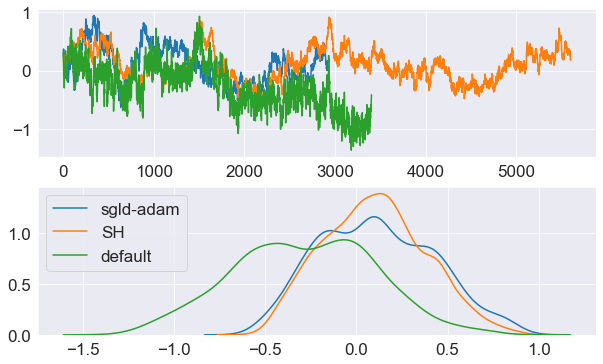

In [111]:
idx = 1000

fig, ax = plt.subplots(2, figsize=(10, 6))

ax[0].plot(flat_adam[:,idx], label="sgld-adam")
ax[0].plot(flat_SH[:,idx], label="SH")
ax[0].plot(flat_default[:,idx], label="default")

sns.kdeplot(flat_adam[:,idx], ax=ax[1], label="sgld-adam")
sns.kdeplot(flat_SH[:,idx], ax=ax[1], label="SH")
sns.kdeplot(flat_default[:,idx], ax=ax[1], label="default")

plt.legend()
plt.show()


# KSD curves: svrg

_Tune step size, batch size, and update rate_

#### R = 10sec with n=120


`key=0`:
- v1: -5.063, 0.0085, 9213
- v2: -5.17, 0.0067, 2474
- v3: -5.28, 0.0026, 5047

`key=1`:
- v4: -4.99, 0.0108, 288
- v5: -5.11, 0.011, 9336
- v6: -5.24, 0.0016, 8689

`key=2`:
- v7: -4.557, 0.0085, 8770
- v8: -4.69, 0.0053, 7146
- v9: -4.59, 0.0016, 132

 
 
#### R = 15sec with n=90. Fixed `update_rate`


`key=0`:
- v1: -4.73, 0.0038
- v2: -4.69, 0.0081
- v3: -5.032, 0.0011

`key=1`:
- v4: -4.49, 0.027
- v5: -4.72, 0.033
- v6: -5.01, 0.0022

`key=2`:
- v7: -4.49, 0.0023
- v8: -4.701, 0.028
- v9: -4.89, 0.0012

 

In [4]:
def run_many_KSD_curves_svrg(list_params):
    list_KSD_curves = []
    
    starttime = time.time()
    for log_dt, b_s_r in list_params:
        print(f"\nCalculating KSD curve for {log_dt, b_s_r}:")
        def run_svrg_sampler(time_budget):
            key = random.PRNGKey(0)
            MAP_params = load_PMF_MAP()
            dt = 10**(log_dt)
            update_rate = 1000
            batch_size = int(b_s_r*R_train.shape[0])
            samples, _ = sgld_PMF_time_budget_svrg(key, time_budget, grad_log_post, dt, 
                               batch_size, MAP_params, R_train, update_rate, save_rate=30)
            return samples
        
        # ===
        max_time_budget =  20
        time_steps = 2
        thin_step = 2
        
        ksd_list_sgld_SH = get_KSD_list_time_budget_PMF(max_time_budget, time_steps, 
                                                        run_svrg_sampler, thin_step=thin_step)
        list_KSD_curves.append(ksd_list_sgld_SH)
    print(f"Running time: {(time.time()-starttime)/60:.1f} min")
    return list_KSD_curves

In [5]:
# n=120
# list_params_svrg_10 = [(-5.063, 0.0085, 9213), (-5.17, 0.0067, 2474), (-5.28, 0.0026, 5047),
#                        (-4.99, 0.0108, 288), (-5.11, 0.011, 9336), (-5.24, 0.0016, 8689),
#                        (-4.557, 0.0085, 8770), (-4.69, 0.0053, 7146), (-4.59, 0.0016, 132)
#                      ]

# fixed update_rate
list_params_svrg_15 = [(-4.73, 0.0038), (-4.69, 0.0081), (-5.032, 0.0011),
                       (-4.49, 0.027), (-4.72, 0.033), (-5.01, 0.0022),
                       (-4.49, 0.0023), (-4.701, 0.028), (-4.89, 0.0012)
                     ]

# list_params_svrg_10 = [(-5.063, 0.0085, 9213),
#                      ]

# list_KSD_curves_svrg_10 = run_many_KSD_curves_svrg(list_params_svrg_15)




Calculating KSD curve for (-4.73, 0.0038):
Running for time budget=5sec
Num samples: 85
KSD: 455.4


Running for time budget=7sec
Num samples: 114
KSD: 394.3


Running for time budget=9sec
Num samples: 144
KSD: 350.2


Running for time budget=11sec
Num samples: 170
KSD: 322.4


Running for time budget=13sec
Num samples: 200
KSD: 297.1


Running for time budget=15sec
Num samples: 235
KSD: 274.0


Running for time budget=17sec
Num samples: 238
KSD: 272.8


Running for time budget=19sec
Num samples: 284
KSD: 249.7



Calculating KSD curve for (-4.69, 0.0081):
Running for time budget=5sec
Num samples: 81
KSD: 455.1


Running for time budget=7sec
Num samples: 113
KSD: 383.9


Running for time budget=9sec
Num samples: 138
KSD: 347.9


Running for time budget=11sec
Num samples: 163
KSD: 319.1


Running for time budget=13sec
Num samples: 192
KSD: 294.6


Running for time budget=15sec
Num samples: 224
KSD: 272.9


Running for time budget=17sec
Num samples: 252
KSD: 257.3


Running for time bud

In [9]:
# n=120
# save all KSD curves
# for idx, elem in enumerate(list_KSD_curves_svrg_10):
#     np.savetxt(f"outputs/KSD_list/PMF/svrg-SH_15-n_90/ksd_curve_{idx}.csv", elem)

# load all KSD curves
list_KSD_curves_svrg_10 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/PMF/svrg-SH_15-n_90/ksd_curve_{idx}.csv")
    list_KSD_curves_svrg_10.append(mylist)
    
    

In [10]:
list_KSD_curves_svrg_10

[array([455.43768311, 394.27474976, 350.22244263, 322.4050293 ,
        297.05664062, 273.99975586, 272.83139038, 249.66807556]),
 array([455.06643677, 383.88378906, 347.86303711, 319.0690918 ,
        294.59414673, 272.93701172, 257.34469604, 244.00201416]),
 array([498.26361084, 438.83755493, 419.90316772, 375.67425537,
        346.26776123, 326.41818237, 307.89923096, 294.46243286]),
 array([442.38024902, 381.15130615, 347.86758423, 317.16049194,
        288.13928223, 272.95495605, 251.05812073, 232.7552948 ]),
 array([492.67800903, 428.41751099, 384.53497314, 356.89511108,
        326.67340088, 304.52328491, 287.93115234, 270.58209229]),
 array([491.57086182, 441.95230103, 402.27075195, 372.80401611,
        341.24319458, 323.6857605 , 306.1572876 , 289.38101196]),
 array([433.53158569, 368.86380005, 341.43347168, 303.06768799,
        276.04632568, 262.41610718, 240.38043213, 228.5695343 ]),
 array([495.13174438, 419.68060303, 384.05883789, 353.21798706,
        319.34103394, 299.

In [11]:
def svrg_sampler_default(time_budget):
    
    key = random.PRNGKey(0)
    MAP_params = load_PMF_MAP()
    dt = 10**(-3.75)
    batch_size = int(0.1*R_train.shape[0])
    update_rate = 1000
    samples, _ = sgld_PMF_time_budget_svrg(key, time_budget, grad_log_post, dt, 
                       batch_size, MAP_params, R_train, update_rate, save_rate=30)
    return samples


# ===
max_time_budget = 20
time_steps = 2
thin_step = 2
ksd_list_svrg_default = get_KSD_list_time_budget_PMF(max_time_budget, time_steps, svrg_sampler_default, thin_step=thin_step)



Running for time budget=5sec
Num samples: 45
KSD: 1424.6


Running for time budget=7sec
Num samples: 63
KSD: 1048.7


Running for time budget=9sec
Num samples: 76
KSD: 894.8


Running for time budget=11sec
Num samples: 102
KSD: 684.5


Running for time budget=13sec
Num samples: 124
KSD: 574.5


Running for time budget=15sec
Num samples: 126
KSD: 566.4


Running for time budget=17sec
Num samples: 138
KSD: 522.9


Running for time budget=19sec
Num samples: 168
KSD: 439.9




In [12]:
# np.savetxt(f"outputs/KSD_list/PMF/ksd_curve_svrg_default.csv", ksd_list_svrg_default)

ksd_list_svrg_default = np.genfromtxt(f"outputs/KSD_list/PMF/ksd_curve_svrg_default.csv")


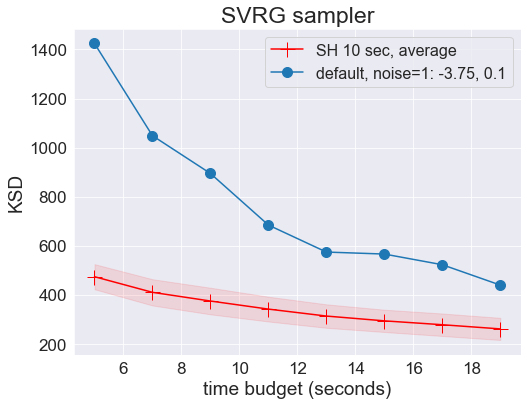

In [14]:
plt.rcParams.update({'font.size':17})

average_curve_svrg_SH10 = np.mean(list_KSD_curves_svrg_10, axis=0)
std_curve_svrg_SH10 = np.std(list_KSD_curves_svrg_10, axis=0)



max_time_budget = 20

plt.figure(figsize=(8, 6))

plt.plot(np.arange(5, max_time_budget, 2), average_curve_svrg_SH10, marker="+", markersize=15, 
         c='r', label="SH 10 sec, average")
plt.fill_between(np.arange(5, max_time_budget, 2), average_curve_svrg_SH10+2*std_curve_svrg_SH10, 
                 average_curve_svrg_SH10-2*std_curve_svrg_SH10, alpha=0.1, color='r')



# for elem in list_KSD_curves_svrg_10[:]:
#     plt.plot(np.arange(5, max_time_budget, 2), elem, alpha=0.4, marker="v")
    
plt.plot(np.arange(5, max_time_budget, 2), ksd_list_svrg_default, marker="o", label="default, noise=1: -3.75, 0.1", markersize=10)


plt.title("SVRG sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/PMF_sgld_ksd_curves.png") 

### variance estimate


#### run samplers

In [70]:
key = random.PRNGKey(0)

# use parameters from the 1st SH chain (from list_params_sgld_10`)
dt = 10**(-4.73)
batch_size = int(0.0038*R_train.shape[0])
time_budget = 200.
update_rate = 1000

samples_svrg_SH, _ = sgld_PMF_time_budget_svrg(key, time_budget, grad_log_post, dt, 
                               batch_size, load_PMF_MAP(), R_train, update_rate, save_rate=30)


print(f"Number of samples: {len(samples_svrg_SH)*30:,}")

Number of samples: 67,860


In [71]:
key = random.PRNGKey(0)

dt = 10**(-3.75)
batch_size = int(0.1*R_train.shape[0])
# time_budget = 10.
update_rate = 2001

samples_svrg_default, _ = sgld_PMF_time_budget_svrg(key, time_budget, grad_log_post, dt, 
                               batch_size, load_PMF_MAP(), R_train, update_rate, save_rate=30)


print(f"Number of samples: {len(samples_svrg_default)*30:,}")


Number of samples: 46,230


#### variance

In [72]:
from config import BASE_DIR

def load_PMF_NUTS_stds():
    return [np.genfromtxt(f"{BASE_DIR}/data/PMF_NUTS_stds/PMF_{idx}_std.txt") for idx in range(6)]


numpyro_stds = load_PMF_NUTS_stds()

In [76]:
samples_std_svrg_SH = []
for idx in range(6):
    samples_std_svrg_SH.append(np.std([elem[idx] for elem in samples_svrg_SH], axis=0))

list_rel_error_svrg_SH = []
for idx in range(6):
        list_rel_error_svrg_SH.append(np.linalg.norm(samples_std_svrg_SH[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

        
mean_variance_error_svrg_SH = np.mean(list_rel_error_svrg_SH)

print(f"Variance estimation error for 1 SH chain: {mean_variance_error_svrg_SH:.2f}")


Variance estimation error for 1 SH chain: 0.87


In [77]:
samples_std_svrg_default = []
for idx in range(6):
    samples_std_svrg_default.append(np.std([elem[idx] for elem in samples_svrg_default], axis=0))

list_rel_error_svrg_default = []
for idx in range(6):
        list_rel_error_svrg_default.append(np.linalg.norm(samples_std_svrg_default[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

        
mean_variance_error_svrg_default = np.mean(list_rel_error_svrg_default)

print(f"Variance estimation error for the gridsearch chain: {mean_variance_error_svrg_default:.2f}")


Variance estimation error for the gridsearch chain: 5.58


# sghmc

#### R = 30sec, with n=120, thin_step=5


`key=9`:
- v1: -5.34, 0.081, 3
- v2: -6.32, 0.01, 5
- v3: -4.62, 0.027, 8

<!-- key=10 -->
<!-- - v4: -3.31, 0.1, 2 -->
<!-- - v5: -4.15, 0.027, 4 -->
<!-- - v6: -6.65, 0.011, 9 -->
`key=8`:
- v4: -5.27, 0.017, 2
- v5: -5.96, 0.0022, 4
- v6: -5.91, 0.001, 3

`key=11`:
- v7: -5.19, 0.071, 2
- v8: -3.22, 0.33, 2
- v9: -6.27, 0.0031, 6

 

In [ ]:
time_budget = 1

key = random.PRNGKey(1)
dt = 1e-5
batch_size = int(R_train.shape[0]*0.05)
params = load_PMF_MAP()
L = 10

samples_pmf_sghmc, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, batch_size, 
                                                 L, R_train, params, save_rate=10)

# samples_pmf_sghmc = samples_pmf_sghmc + samples_pmf_sghmc2

In [53]:
def run_many_KSD_curves_sghmc(list_params):
    list_KSD_curves = []
    
    starttime = time.time()
    for log_dt, b_s_r, L in list_params:
        print(f"\nCalculating KSD curve for {log_dt, b_s_r, L}:")
        def run_sghmc_sampler(time_budget):
            key = random.PRNGKey(0)
            MAP_params = load_PMF_MAP()
            dt = 10**(log_dt)
            batch_size = int(b_s_r*R_train.shape[0])
            samples, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, batch_size, 
                                             L, R_train, MAP_params, save_rate=10)
            return samples
        
        # ===
        max_time_budget =  30
        time_steps = 2
        thin_step = 2
        
        ksd_list_sgld_SH = get_KSD_list_time_budget_PMF(max_time_budget, time_steps, 
                                                        run_sghmc_sampler, thin_step=thin_step, start_time=15)
        list_KSD_curves.append(ksd_list_sgld_SH)
    print(f"Running time: {(time.time()-starttime)/60:.1f} min")
    return list_KSD_curves

In [93]:
# n=120
list_params_sghmc_30 = [(-5.34, 0.081, 3), (-6.32, 0.01, 5), (-4.62, 0.027, 8),
                        (-5.27, 0.017, 2), (-5.96, 0.0022, 4), (-5.91, 0.001, 3),
                        (-5.19, 0.071, 2), (-3.22, 0.33, 2), (-6.27, 0.0031, 6)
                       ]



# list_KSD_curves_sghmc_SH30_extra = run_many_KSD_curves_sghmc(list_params_sghmc_30)


Calculating KSD curve for (-5.27, 0.017, 2):
Running for time budget=15sec
Iteration 1000. Time: 3 / 15 sec
Iteration 2000. Time: 6 / 15 sec
Iteration 3000. Time: 8 / 15 sec
Iteration 4000. Time: 11 / 15 sec
Iteration 5000. Time: 14 / 15 sec
Num samples: 525
KSD: 357.5


Running for time budget=17sec
Iteration 1000. Time: 3 / 17 sec
Iteration 2000. Time: 6 / 17 sec
Iteration 3000. Time: 9 / 17 sec
Iteration 4000. Time: 12 / 17 sec
Iteration 5000. Time: 15 / 17 sec
Num samples: 558
KSD: 349.0


Running for time budget=19sec
Iteration 1000. Time: 3 / 19 sec
Iteration 2000. Time: 6 / 19 sec
Iteration 3000. Time: 9 / 19 sec
Iteration 4000. Time: 13 / 19 sec
Iteration 5000. Time: 17 / 19 sec
Num samples: 561
KSD: 348.0


Running for time budget=21sec
Iteration 1000. Time: 3 / 21 sec
Iteration 2000. Time: 6 / 21 sec
Iteration 3000. Time: 10 / 21 sec
Iteration 4000. Time: 13 / 21 sec
Iteration 5000. Time: 19 / 21 sec
Num samples: 578
KSD: 344.0


Running for time budget=23sec
Iteration 1000.

In [10]:
# n=90
# save all KSD curves
# for idx, elem in enumerate(new_list_KSD_curves_sghmc_SH30_extra):
#     np.savetxt(f"outputs/KSD_list/PMF/sghmc-SH_30-n_120/ksd_curve_{idx}.csv", elem)

# load all KSD curves
list_KSD_curves_sghmc_SH30 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/PMF/sghmc-SH_30-n_120/ksd_curve_{idx}.csv")
    list_KSD_curves_sghmc_SH30.append(mylist)

#### sghmc: default

In [36]:
# def sghmc_sampler_default(time_budget):
    
#     key = random.PRNGKey(0)
#     MAP_params = load_PMF_MAP()
#     dt = 10**(-5)
#     batch_size = int(0.1*R_train.shape[0])
#     L = 26
#     samples, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, batch_size, 
#                                      L, R_train, MAP_params, save_rate=10)
#     return samples


# # ===
# max_time_budget = 30
# time_steps = 2
# thin_step = 2
# ksd_list_sghmc_default = get_KSD_list_time_budget_PMF(max_time_budget, time_steps, 
#                                              sghmc_sampler_default, thin_step=thin_step, start_time=15)



Running for time budget=15sec
Num samples: 26
KSD: 2317.2


Running for time budget=17sec
Num samples: 19
KSD: 2685.5


Running for time budget=19sec
Num samples: 24
KSD: 2421.8


Running for time budget=21sec
Num samples: 30
KSD: 2134.2


Running for time budget=23sec
Num samples: 32
KSD: 2063.1


Running for time budget=25sec
Num samples: 34
KSD: 2004.8


Running for time budget=27sec
Num samples: 34
KSD: 2004.8


Running for time budget=29sec
Num samples: 38
KSD: 1890.1




In [11]:
# np.savetxt(f"outputs/KSD_list/PMF/ksd_list_sghmc_default.csv", ksd_list_sghmc_default)

ksd_list_sghmc_default = np.genfromtxt(f"outputs/KSD_list/PMF/ksd_list_sghmc_default.csv")


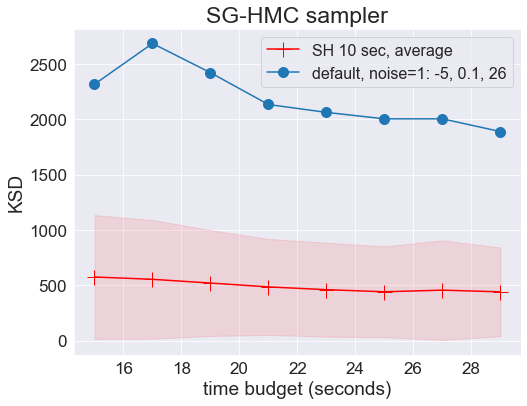

In [12]:
plt.rcParams.update({'font.size':17})

average_curve_sghmc_SH30 = np.nanmean(list_KSD_curves_sghmc_SH30, axis=0)
std_curve_sghmc_SH30 = np.nanstd(list_KSD_curves_sghmc_SH30, axis=0)



max_time_budget = 30

plt.figure(figsize=(8, 6))

plt.plot(np.arange(15, max_time_budget, 2), average_curve_sghmc_SH30, marker="+", markersize=15, 
         c='r', label="SH 10 sec, average")
plt.fill_between(np.arange(15, max_time_budget, 2), average_curve_sghmc_SH30+2*std_curve_sghmc_SH30, 
                 average_curve_sghmc_SH30-2*std_curve_sghmc_SH30, alpha=0.1, color='r')



# for elem in list_KSD_curves_sghmc_SH30[6:9]:
#     plt.plot(np.arange(15, max_time_budget, 2), elem, alpha=0.4, marker="v")
    
plt.plot(np.arange(15, max_time_budget, 2), ksd_list_sghmc_default, marker="o", 
                     label="default, noise=1: -5, 0.1, 26", markersize=10)


plt.title("SG-HMC sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/PMF_sghmc_ksd_curves.png") 

In [13]:
ls images

LR_KSD_curves.png            PMF_KSD_curves.png
LR_KSD_curves_2_budgets.png


### variance estimates


Errors:

- SH1:  0.95
- default: 5.71

In [118]:
key = random.PRNGKey(0)

# use parameters from the 1st SH chain (from list_params_sghmc_30`)
dt = 10**(-5.34)
batch_size = int(0.081*R_train.shape[0])
time_budget = 200.
L = 3

samples_sghmc_SH, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, batch_size, 
                                     L, R_train, load_PMF_MAP(), save_rate=50)


print(f"Number of samples: {len(samples_sghmc_SH)*50:,}")

Iteration 1000. Time: 7 / 200.0 sec
Iteration 2000. Time: 13 / 200.0 sec
Iteration 3000. Time: 18 / 200.0 sec
Iteration 4000. Time: 24 / 200.0 sec
Iteration 5000. Time: 30 / 200.0 sec
Iteration 6000. Time: 36 / 200.0 sec
Iteration 7000. Time: 42 / 200.0 sec
Iteration 8000. Time: 48 / 200.0 sec
Iteration 9000. Time: 56 / 200.0 sec
Iteration 10000. Time: 70 / 200.0 sec
Iteration 11000. Time: 83 / 200.0 sec
Iteration 12000. Time: 97 / 200.0 sec
Iteration 13000. Time: 108 / 200.0 sec
Iteration 14000. Time: 124 / 200.0 sec
Iteration 15000. Time: 135 / 200.0 sec
Iteration 16000. Time: 145 / 200.0 sec
Iteration 17000. Time: 160 / 200.0 sec
Iteration 18000. Time: 181 / 200.0 sec
Iteration 19000. Time: 192 / 200.0 sec
Number of samples: 19,600


In [119]:
key = random.PRNGKey(0)

dt = 10**(-5)
batch_size = int(0.1*R_train.shape[0])
time_budget = 200.
L = 26

samples_sghmc_default, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, batch_size, 
                                     L, R_train, load_PMF_MAP(), save_rate=50)


print(f"Number of samples: {len(samples_sghmc_default)*50:,}")

Iteration 1000. Time: 123 / 200.0 sec
Number of samples: 1,600


#### variances

In [120]:
from config import BASE_DIR

def load_PMF_NUTS_stds():
    return [np.genfromtxt(f"{BASE_DIR}/data/PMF_NUTS_stds/PMF_{idx}_std.txt") for idx in range(6)]


numpyro_stds = load_PMF_NUTS_stds()

In [121]:
samples_std_sghmc_SH = []
for idx in range(6):
    samples_std_sghmc_SH.append(np.std([elem[idx] for elem in samples_sghmc_SH], axis=0))

list_rel_error_sghmc_SH = []
for idx in range(6):
        list_rel_error_sghmc_SH.append(np.linalg.norm(samples_std_sghmc_SH[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

        
mean_variance_error_sghmc_SH = np.mean(list_rel_error_sghmc_SH)

print(f"Variance estimation error for 1 SH chain: {mean_variance_error_sghmc_SH:.2f}")


Variance estimation error for 1 SH chain: 0.95


In [122]:
samples_std_sghmc_default = []
for idx in range(6):
    samples_std_sghmc_default.append(np.std([elem[idx] for elem in samples_sghmc_default], axis=0))

list_rel_error_sghmc_default = []
for idx in range(6):
        list_rel_error_sghmc_default.append(np.linalg.norm(samples_std_sghmc_default[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

        
mean_variance_error_sghmc_default = np.mean(list_rel_error_sghmc_default)

print(f"Variance estimation error for the gridsearch chain: {mean_variance_error_sghmc_default:.2f}")


Variance estimation error for the gridsearch chain: 5.71


# 3 plots together

In [2]:
# SGLD
list_KSD_curves_sgld_10 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/PMF/sgld-SH_10-n_90/ksd_curve_{idx}.csv")
    list_KSD_curves_sgld_10.append(mylist)

ksd_list_adam = np.genfromtxt(f"outputs/KSD_list/PMF/ksd_curve_adam.csv")
ksd_list_sgld_default = np.genfromtxt(f"outputs/KSD_list/PMF/ksd_curve_sgld_default.csv")

# =====
# SVRG
list_KSD_curves_svrg_10 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/PMF/svrg-SH_15-n_90/ksd_curve_{idx}.csv")
    list_KSD_curves_svrg_10.append(mylist)
    
ksd_list_svrg_default = np.genfromtxt(f"outputs/KSD_list/PMF/ksd_curve_svrg_default.csv")


# =====
# SGHMC

list_KSD_curves_sghmc_SH30 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/PMF/sghmc-SH_30-n_120/ksd_curve_{idx}.csv")
    list_KSD_curves_sghmc_SH30.append(mylist)
    
ksd_list_sghmc_default = np.genfromtxt(f"outputs/KSD_list/PMF/ksd_list_sghmc_default.csv")

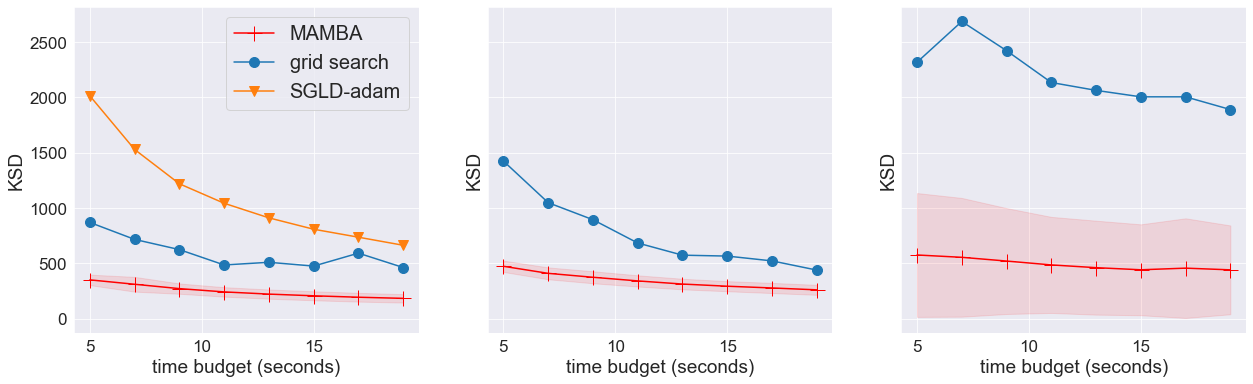

In [4]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(1,3, figsize=(21, 6), sharey=True)


# ===============
# SGLD
average_curve_sgld_SH10 = np.mean(list_KSD_curves_sgld_10, axis=0)
std_curve_sgld_SH10 = np.std(list_KSD_curves_sgld_10, axis=0)

max_time_budget_sgld = 20

ax[0].plot(np.arange(5, max_time_budget_sgld, 2), average_curve_sgld_SH10, marker="+", markersize=15, 
         c='r', label="MAMBA")
ax[0].fill_between(np.arange(5, max_time_budget_sgld, 2), average_curve_sgld_SH10+2*std_curve_sgld_SH10, 
                 average_curve_sgld_SH10-2*std_curve_sgld_SH10, alpha=0.1, color='r')

ax[0].plot(np.arange(5, max_time_budget_sgld,2), ksd_list_sgld_default, marker="o", label="grid search", markersize=10)
ax[0].plot(np.arange(5, max_time_budget_sgld,2), ksd_list_adam, marker="v", label="SGLD-adam", markersize=10)


# ax[0].set_title("SGLD sampler", size=23)
ax[0].set_ylabel("KSD", size=19)
ax[0].set_xlabel("time budget (seconds)", size=19)
# ax[0].legend(fontsize=20)



# ===============
# # SVRG

average_curve_sgldCV_SH10 = np.mean(list_KSD_curves_svrg_10, axis=0)
std_curve_sgldCV_SH10 = np.std(list_KSD_curves_svrg_10, axis=0)

max_time_budget_sgldCV = 20

ax[1].plot(np.arange(5, max_time_budget_sgldCV,2), average_curve_sgldCV_SH10, marker="+", markersize=15, 
         c='r', label="SH")
ax[1].fill_between(np.arange(5, max_time_budget_sgldCV,2), average_curve_sgldCV_SH10+2*std_curve_sgldCV_SH10, 
                 average_curve_sgldCV_SH10-2*std_curve_sgldCV_SH10, alpha=0.1, color='r')

ax[1].plot(np.arange(5, max_time_budget_sgldCV, 2), ksd_list_svrg_default, marker="o", label="default: -4.8, 0.1", markersize=10)

# ax[1].set_title("SVRG sampler", size=23)
ax[1].set_ylabel("KSD", size=19)
ax[1].set_xlabel("time budget (seconds)", size=19)
# ax[1].legend(fontsize=20)


# ==================
# SG-HMC
average_curve_sghmc_SH10 = np.mean(list_KSD_curves_sghmc_SH30, axis=0)
std_curve_sghmc_SH10 = np.std(list_KSD_curves_sghmc_SH30, axis=0)

max_time_budget_sghmc = 20

ax[2].plot(np.arange(5, max_time_budget_sghmc,2), average_curve_sghmc_SH10, marker="+", markersize=15, 
         c='r', label="SH 10 sec, average")
ax[2].fill_between(np.arange(5, max_time_budget_sghmc,2), average_curve_sghmc_SH10+2*std_curve_sghmc_SH10, 
                 average_curve_sghmc_SH10-2*std_curve_sghmc_SH10, alpha=0.1, color='r')
    
ax[2].plot(np.arange(5, max_time_budget_sghmc,2), ksd_list_sghmc_default, marker="o", label="grid search", markersize=10)

# ax[2].set_title("SG-HMC sampler", size=23)
ax[2].set_ylabel("KSD", size=19)
ax[2].set_xlabel("time budget (seconds)", size=19)


ax[0].legend(fontsize=20)

# plt.savefig("images/PMF_KSD_curves.png")

